## List of tables:
### 1. [Table 3: Treatment effects on quantity](#quantity)

## List of figures:
### 2. [Figure 1: Distribution of fragments submitted](#icdf)

In [18]:
%matplotlib inline

#### Imports libraries

In [1]:
import matplotlib.pyplot as plt  # Plotting
import os  # File system handling
import pandas as pd  # Dataframe handling
import statsmodels.formula.api as smf  # Regressions analysis

from matplotlib.ticker import FuncFormatter  # Formating graphs
from scipy import stats  # Statistics module
from statsmodels.iolib.summary2 import summary_col  # Regression output table
from statsmodels.stats.anova import anova_lm  # Regression anova table
from statsmodels.stats.multicomp import MultiComparison  # Multi-comparisson tests
from statsmodels.stats.proportion import proportions_ztest # proportion Z-test

#### Set project directory

In [2]:
PROJECT_FOLDER = os.path.dirname(os.getcwd())
FINAL_DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data', 'final')
TABLES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'tables')
FIGURES_FOLDER = os.path.join(PROJECT_FOLDER, 'reports', 'figures')

#### Pandas options

In [3]:
pd.set_option("display.precision", 3)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_rows", 40)

#### Set plotting style

In [4]:
plt.style.use('classic')

#### Set plotting properties 

In [5]:
bar_kw = dict(kind='bar', color='0.4')
line_kw = dict(kind='line', lw=1, alpha=1, legend=True)
font_kw = dict(fontsize=11, color='k')
grid_kw = dict(linewidth=1, axis="y", zorder=2, antialiased=True)
xlab_kw = dict(fontsize=11, labelpad=3)
ylab_kw = dict(fontsize=11, labelpad=3)
error_kw = dict(elinewidth=2, ecolor='0.15')
legend_kw = dict(frameon=False)
tick_kw = dict(size=5,
               which='both',
               direction='out',
               right=False,
               top=False,
               labelbottom=True)

#### Retrieving dataframe

In [6]:
DATA = os.path.join(FINAL_DATA_FOLDER, 'fair_advice_final.feather')
df = pd.read_feather(DATA)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3598 entries, 0 to 3597
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Dataset                   3598 non-null   int64         
 1   SubmitTime                3598 non-null   datetime64[ns]
 2   Duration                  3598 non-null   int64         
 3   Controlquestion           1799 non-null   float64       
 4   Controlquestion_attempts  1799 non-null   float64       
 5   Treatment                 3598 non-null   int64         
 6   Treatment_name            3598 non-null   object        
 7   Dictator                  3598 non-null   int64         
 8   Decision                  3598 non-null   int64         
 9   Advise                    1799 non-null   float64       
 10  Follow                    1799 non-null   float64       
 11  Belief1                   598 non-null    float64       
 12  Belief2             

In [7]:
df = df[(df['Risk'] == 0)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1811 entries, 1 to 3597
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Dataset                   1811 non-null   int64         
 1   SubmitTime                1811 non-null   datetime64[ns]
 2   Duration                  1811 non-null   int64         
 3   Controlquestion           903 non-null    float64       
 4   Controlquestion_attempts  903 non-null    float64       
 5   Treatment                 1811 non-null   int64         
 6   Treatment_name            1811 non-null   object        
 7   Dictator                  1811 non-null   int64         
 8   Decision                  1811 non-null   int64         
 9   Advise                    908 non-null    float64       
 10  Follow                    908 non-null    float64       
 11  Belief1                   302 non-null    float64       
 12  Belief2             

#### Selector for only 'Free advice' treatment

In [8]:
df_free = df[(df['Free'] == 1)]

#### How many player X believe  that player Y will follow?

In [9]:
df_free.loc[(df_free['Dictator'] == 1), 'Belief1'].agg(['mean', 'sem', 'count']).to_frame()

,Belief1
mean,0.752
sem,0.025
count,302.000


#### How many player Y follow?

In [10]:
df_free.loc[(df_free['Dictator'] == 0), 'Follow'].agg(['mean', 'sem', 'count']).to_frame()

,Follow
mean,0.744
sem,0.025
count,301.000


In [11]:
cross_table = pd.crosstab(
        df.loc[(df['Dictator'] == 1) & (df['Free'] == 1), 'Decision'],
        df.loc[(df['Dictator'] == 1) & (df['Free'] == 1), 'Belief1'],
        margins=False,
        normalize=False)\
    .rename({0:'Player Y will not follow', 1:'Player Y will follow'}, axis=1)\
    .rename_axis('Belief', axis=1)\
    .rename({0:'Fair', 1:'Selfish'}, axis=0)\
    .rename_axis('Decision', axis=0)

cross_table.to_latex(
    os.path.join(TABLES_FOLDER, 'cross_table_belief1.tex'),
    bold_rows=False,
    float_format="%.3f"
)

display(cross_table)

Belief,Player Y will not follow,Player Y will follow
Decision,,
Fair,52,143
Selfish,23,84


In [14]:
chi_val, p_val, dof, expected = stats.chi2_contingency(cross_table)
print(f'Chi: {chi_val:.3f}, p-value: {p_val:.3f} ')

Chi: 0.732, p-value: 0.392 


In [15]:
odds_ratio, p_value = stats.fisher_exact(cross_table, alternative='two-sided')
print(f'Odds-ratio={odds_ratio:.3f}, p-value={p_value:.3f}')

Odds-ratio=1.328, p-value=0.334


In [16]:
df_belief1 = df_free\
    .loc[(df_free['Dictator'] == 1)]\
    .groupby('Belief1')['Decision']\
    .agg(['mean', 'sem', 'count'])\
    .rename({0:'Player Y will not follow', 1:'Player Y will follow'}, axis=0)

display(df_belief1)

,mean,sem,count
Belief1,,,
Player Y will not follow,0.307,0.054,75
Player Y will follow,0.370,0.032,227


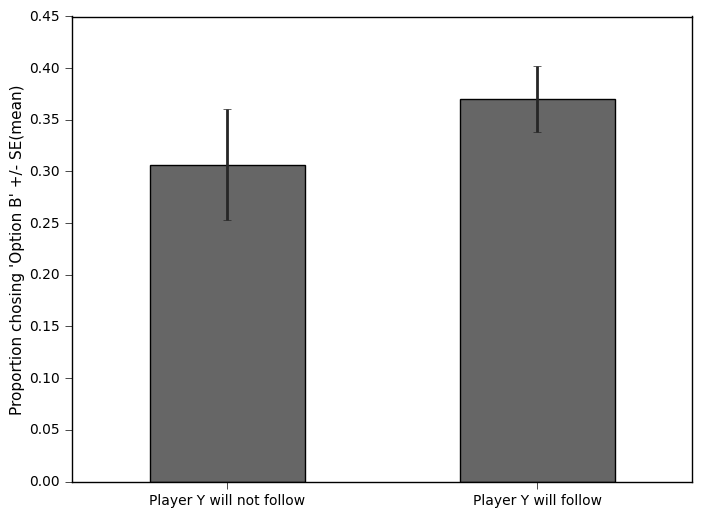

In [19]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=100, facecolor='w')
df_belief1['mean'].plot(yerr=df_belief1['sem'], ax=ax, error_kw=error_kw, **bar_kw)
ax.set_ylabel("Proportion chosing 'Option B' +/- SE(mean)", **ylab_kw)
ax.set_xlabel("")
ax.tick_params(rotation=0, **tick_kw)

path = os.path.join(
    FIGURES_FOLDER,  
    'decision_advice.pdf'
)
fig.savefig(path, bbox_inches='tight')

In [20]:
df = df[(df['Dictator'] == 1) & (df['Risk'] == 0)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 903 entries, 1799 to 3597
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Dataset                   903 non-null    int64         
 1   SubmitTime                903 non-null    datetime64[ns]
 2   Duration                  903 non-null    int64         
 3   Controlquestion           903 non-null    float64       
 4   Controlquestion_attempts  903 non-null    float64       
 5   Treatment                 903 non-null    int64         
 6   Treatment_name            903 non-null    object        
 7   Dictator                  903 non-null    int64         
 8   Decision                  903 non-null    int64         
 9   Advise                    0 non-null      float64       
 10  Follow                    0 non-null      float64       
 11  Belief1                   302 non-null    float64       
 12  Belief2           

In [21]:
df.loc[:, 'Disbelieve'] = 0
df.loc[df['Belief1'] == 0, 'Disbelieve'] = 1
df['Disbelieve'].value_counts()

0    828
1     75
Name: Disbelieve, dtype: int64

In [22]:
for cov in ['Age', 'Education', 'Political']:
    df[f'{cov}_m'] = (df[cov] > df[cov].median()).astype(int)

In [25]:
regs = dict()
regs['reg1'] = 'Decision ~ Binding + Free + Free:Disbelieve'
regs['reg2'] = regs['reg1'] + ' + Age_m + Female + Education_m + Political_m'

ols_results = [smf.ols(formula=v, data=df).fit(cov_type='HC1') for v in regs.values()]

order = [
    'Binding',
    'Free',
    'Free:Disbelieve',
    'Disbelieve',
    'Age_m',
    'Female',
    'Education_m',
    'Political_m',
    'Intercept',
]

auxiliary = {
    'N': lambda x: f'{x.nobs:.0f}',
    'F': lambda x: f'{x.fvalue:.3f}', 
    'P(>F)': lambda x: f'{x.f_pvalue:.3f}',
}

ols_quant = summary_col(
    ols_results,
    stars=True,
    info_dict=auxiliary,
    float_format='%.3f',
    regressor_order=order,
)

ols_quant = ols_quant\
    .tables[0]\
    .rename(mapper=lambda x: x.replace(':', ' * '), axis=0)\
    .rename(mapper=lambda x: x.split()[0].replace('Decision', 'p(selfish)'), axis=1)\
    .rename_axis('Dependent variable', axis=1)

ols_quant.to_latex(
    os.path.join(TABLES_FOLDER, 'ols_decision_robust.tex'),
    bold_rows=False,
    float_format="%.3f"
)

display(ols_quant)

Dependent variable,p(selfish),p(selfish)
Binding,-0.135***,-0.134***
,(0.040),(0.040)
Free,-0.183***,-0.176***
,(0.043),(0.043)
Free * Disbelieve,-0.063,-0.091
,(0.062),(0.063)
Age_m,,-0.047
,,(0.033)
Female,,-0.130***
,,(0.033)


#### Post-regression ANOVA 

In [ ]:
anova_lm(*ols_results, robust='hc1')

#### Convert to html

In [ ]:
!jupyter nbconvert --output-dir='./docs' --to html treatment_effects.ipynb